# Hateful Speech Detection With Classic ML and Bert Models
### Description

In this notebook, I aim to explore various methods for detecting hateful speech within the dataset.
   
1. TF-IDF with Linear Regression model
2. Bert model with native Pytorch 
3. Fine-tuning a model with the Trainer API

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from pathlib import Path

from collections import Counter
import random
import operator
from tqdm import tqdm
import time

from wordcloud import WordCloud
from string import punctuation
import nltk
import subprocess

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertModel, BertTokenizer

from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate

%matplotlib inline

2024-03-08 15:28:03.758278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 15:28:03.758393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 15:28:03.889997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the Data

In [3]:
data_full = pd.read_csv('/kaggle/input/hate-speech-detection-curated-dataset/HateSpeechDatasetBalanced.csv')

num_rows, num_cols = data_full.shape
print(f'Rows: {num_rows},  columns: {num_cols}')

data_full.sample(3)

Rows: 726119,  columns: 2


,Content,Label
544034,arrest mayor keisha lance bottoms we stand wit...,1
21818,all jews are stingy,1
396710,ogre game i think that i am all done with my a...,0


In [4]:
data_full.groupby('Label').count()

,Content
Label,
0,361594
1,364525


In [5]:
#The dataset is quite big so we take just 4000 examples of each class
df1 = data_full.query('Label == 0').sample(4000)
df2 = data_full.query('Label == 1').sample(4000)
data = pd.concat([df1, df2], ignore_index=True)

data.shape

(8000, 2)

# Data Exploration  
Let's take a look on the most frequent words for each class

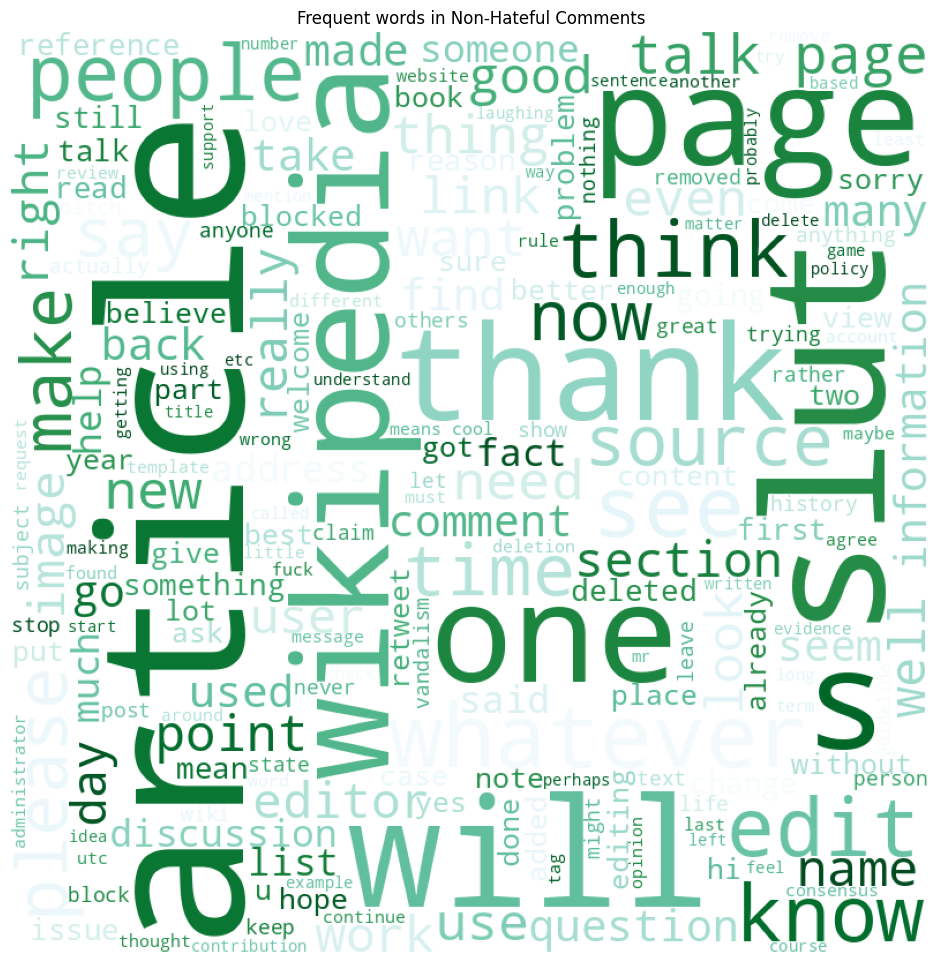

In [6]:
combined_title = ' '.join(df1['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'BuGn',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Non-Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

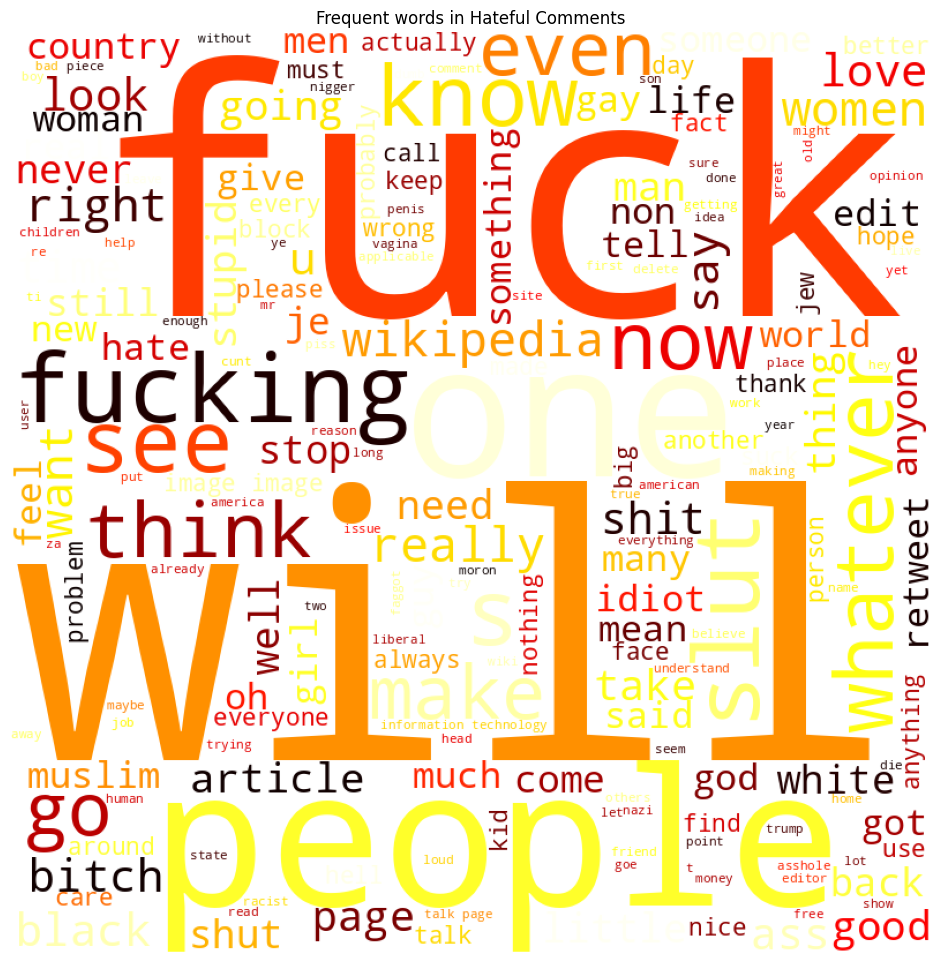

In [7]:
combined_title = ' '.join(df2['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'hot_r',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

# TF-IDF with Linear Regression model  
  
This approach can be considered as baseline.  
Firstly, we need clean and prepare text: clean, remove stopwords, apply lemmatization OR stemming. By default I choose stemming.  
Then convert text to TF-IDF vector and use it as a feature for simple classification model LogisticRegression

In [8]:
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [9]:
data_tfidf = data.copy()

In [10]:
stopwords_l = stopwords.words('english')

punctuation = re.compile("[" + re.escape(string.punctuation) + "]")

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') #Snowball stemmer initialised

def text_cleaning(text, mode="stemming"):
    res = []
    text_clean = re.sub(punctuation,'',text)
    tokens = word_tokenize(text_clean)
    
    for token in tokens:
        if token.lower() not in stopwords_l:
            if mode == "stemming":
                prepared_word = stemmer.stem(token)
            else:
                prepared_word = lemmatizer.lemmatize(token)            
            res.append(prepared_word)
    return ' '.join(res)

In [11]:
data_tfidf['cleaned_text'] = data_tfidf['Content'].apply(text_cleaning)

In [12]:
train, test = train_test_split(data_tfidf, test_size=0.3, stratify=data['Label'], random_state=42)

X_train = train['cleaned_text']
y_train = train['Label']

X_test = test['cleaned_text']
y_test = test['Label']

In [13]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = tfidf_vectorizer.fit_transform(X_train)

X_test_vect = tfidf_vectorizer.transform(X_test)

In [14]:
linear_clf = LogisticRegression()

# train the model with training data processed using TF-IDF
linear_clf.fit(X_train_vect, y_train)

LogisticRegression()

In [15]:
y_pred_tf_idf = linear_clf.predict(X_test_vect)


report = classification_report(y_test, y_pred_tf_idf)
print(report)

display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1200
           1       0.75      0.81      0.78      1200

    accuracy                           0.77      2400
   macro avg       0.77      0.77      0.77      2400
weighted avg       0.77      0.77      0.77      2400



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,868,332
Actual: Hateful,223,977


# Bert model with native Pytorch  
  
Now I want to train Bert model with classification head with native Pytorch.   


In [16]:
train, validation = train_test_split(data, test_size=0.3, stratify=data['Label'], random_state=42)

In [17]:
# Define Dataset 
class HateSpeechDataset(Dataset):
    
    def __init__(self, data):
        
        # Initialize BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')        
        self.data = data
       
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data.iloc[idx]

        text = example["Content"]
        label = example["Label"]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"], ##.unsqueeze(0).int(),
            "label": label,
        }
    

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')      

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
dataset_train = HateSpeechDataset(train)
dataset_val = HateSpeechDataset(validation)

#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader
batch_size = 128
dataloader_train = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: {
        "input_ids": torch.stack([item["input_ids"] for item in x]),
        "attention_mask": torch.stack([item["attention_mask"] for item in x]),
        "labels": torch.tensor([item["label"] for item in x])
    },
    #collate_fn=data_collator,
    pin_memory=True,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: {
        "input_ids": torch.stack([item["input_ids"] for item in x]),
        "attention_mask": torch.stack([item["attention_mask"] for item in x]),
        "labels": torch.tensor([item["label"] for item in x])
    },
    #collate_fn=data_collator,
    pin_memory=True,
)

In [20]:
# Define BERT classifier
class BERTClassifier(nn.Module):
    
    def __init__(self):
        
        # Specify network layers
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)
        
        # Define dropout
        self.dropout = nn.Dropout(0.1)
        
        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False
            
    def forward(self, text, masks):
        #output_bert = self.bert(text, attention_mask=masks).last_hidden_state.mean(axis=1)
        #print(output_bert.last_hidden_state)
        #print(self.bert.config.hidden_size)
        
        output_bert = self.bert(text, attention_mask=masks).last_hidden_state
        output_bert = self.avg_pool(output_bert.transpose(1, 2)).squeeze(-1)
        
        return self.linear(self.dropout(output_bert))

In [21]:
model = BERTClassifier()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [22]:
# Define optimiser, objective function and epochs
optimizer = optim.Adam(model.parameters(), lr=0.001) #optim.AdamW(model.parameters(), lr=5e-5) #
criterion = nn.BCEWithLogitsLoss()
epochs = 5

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Train with native Pytorch

In [24]:
model.to(device)

val_losses = []
train_losses = []

# Train model
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    model.train()
    print(f"Start training epoch {epoch_i}...")
    total_train_loss = 0
    for i, batch in enumerate(tqdm(dataloader_train)):
    
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        label = batch['labels'].to(device) 

        output = model(input_ids, masks)
        loss = criterion(output.squeeze(), label.float())

        loss.backward()
        
        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients".
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)
    # ========================================
    #               Validation
    # ========================================
    
    model.eval()
    print("Start validation...")
    y_true_bert = list()
    y_pred_bert = list()
    
    total_eval_loss = 0.0
    with torch.no_grad():
        for batch in dataloader_val:
            input_ids = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)
            
            output = model(input_ids, masks)
            max_output = (torch.sigmoid(output).cpu().numpy().reshape(-1)>= 0.5).astype(int)
            y_true_bert.extend(label.tolist())
            y_pred_bert.extend(max_output.tolist())
            
            loss_v = criterion(output.squeeze(), label.float())
            total_eval_loss += loss.item()
    avg_val_loss = total_eval_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    
    print(f"Metrics after Epoch {epoch_i}")     
    print(f"Accuracy : {accuracy_score(y_true_bert, y_pred_bert)}")
    print(f"Presision: {np.round(precision_score(y_true_bert, y_pred_bert),3)}")
    print(f"Recall: {np.round(recall_score(y_true_bert, y_pred_bert),3)}") 
    print(f"F1: {np.round(f1_score(y_true_bert, y_pred_bert),3)}")
    print("   ")  
        

Start training epoch 0...


100%|██████████| 44/44 [00:11<00:00,  3.83it/s]

Start validation...


Metrics after Epoch 0
Accuracy : 0.7183333333333334
Presision: 0.731
Recall: 0.691
F1: 0.71
   
Start training epoch 1...


100%|██████████| 44/44 [00:10<00:00,  4.23it/s]

Start validation...


Metrics after Epoch 1
Accuracy : 0.7475
Presision: 0.741
Recall: 0.761
F1: 0.751
   
Start training epoch 2...


100%|██████████| 44/44 [00:10<00:00,  4.20it/s]

Start validation...


Metrics after Epoch 2
Accuracy : 0.7554166666666666
Presision: 0.754
Recall: 0.758
F1: 0.756
   
Start training epoch 3...


100%|██████████| 44/44 [00:10<00:00,  4.18it/s]

Start validation...


Metrics after Epoch 3
Accuracy : 0.7516666666666667
Presision: 0.761
Recall: 0.733
F1: 0.747
   
Start training epoch 4...


100%|██████████| 44/44 [00:10<00:00,  4.19it/s]

Start validation...


Metrics after Epoch 4
Accuracy : 0.7525
Presision: 0.765
Recall: 0.728
F1: 0.746
   


In [25]:
print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_bert, y_pred_bert)))
print('\nClassification report: \n', classification_report(y_true_bert, y_pred_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Test accuracy: 0.75

Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.78      0.76      1200
           1       0.77      0.73      0.75      1200

    accuracy                           0.75      2400
   macro avg       0.75      0.75      0.75      2400
weighted avg       0.75      0.75      0.75      2400


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,932,268
Actual: Hateful,326,874


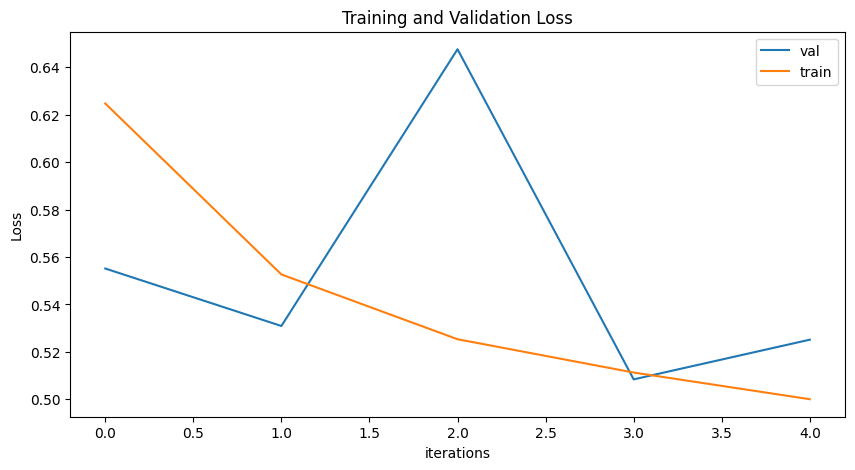

In [26]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Fine-tuning a model with the Trainer API
  
In this section, along with Trainer API, I apply the AutoModelForSequenceClassification. This model automatically includes a classification head, so there's no need for any additional configuration. Train params are default


In [27]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
training_args = TrainingArguments(output_dir="test_trainer", report_to="none")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
metric_acc = evaluate.load("accuracy")
metric_prec = evaluate.load("precision")
metric_recall = evaluate.load("recall")

In [29]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=predictions, references=labels)["accuracy"]
    prec = metric_prec.compute(predictions=predictions, references=labels)["precision"]
    rec = metric_recall.compute(predictions=predictions, references=labels)["recall"]
    
    return {"accuracy": acc,"precision": prec, "recall": rec}

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')    
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
    data_collator = data_collator
    
)

In [32]:
trainer.train()

Step,Training Loss
500,0.533400
1000,0.356400
1500,0.275900
2000,0.134800


TrainOutput(global_step=2100, training_loss=0.3156863871074858, metrics={'train_runtime': 198.5141, 'train_samples_per_second': 84.629, 'train_steps_per_second': 10.579, 'total_flos': 552533216256000.0, 'train_loss': 0.3156863871074858, 'epoch': 3.0})

In [33]:
model.eval()
print("Start validation...")
y_true_auto_bert  = list()
y_pred_auto_bert = list()

total_eval_loss = 0.0
with torch.no_grad():
    for batch in dataloader_val:
        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)

        output = model(input_ids, masks)
        max_output = np.argmax(output.logits.cpu().numpy(), axis=-1)
        y_true_auto_bert.extend(label.tolist())
        y_pred_auto_bert.extend(max_output.tolist())


print(f"Accuracy : {accuracy_score(y_true_auto_bert, y_pred_auto_bert)}")
print(f"Presision: {np.round(precision_score(y_true_auto_bert, y_pred_auto_bert),3)}")
print(f"Recall: {np.round(recall_score(y_true_auto_bert, y_pred_auto_bert),3)}") 
print(f"F1: {np.round(f1_score(y_true_auto_bert, y_pred_auto_bert),3)}")
print("   ")  


print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_auto_bert, y_pred_auto_bert)))
print('\nClassification report: \n', classification_report(y_true_auto_bert, y_pred_auto_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_auto_bert, y_pred_auto_bert)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_true_auto_bert, y_pred_auto_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Start validation...
Accuracy : 0.8279166666666666
Presision: 0.821
Recall: 0.838
F1: 0.83
   
Test accuracy: 0.83

Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      1200
           1       0.82      0.84      0.83      1200

    accuracy                           0.83      2400
   macro avg       0.83      0.83      0.83      2400
weighted avg       0.83      0.83      0.83      2400


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,981,219
Actual: Hateful,194,1006
